<a href="https://colab.research.google.com/github/ThesanR/TorontoPermitClassification/blob/main/PermitClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret[analysis]
!pip install pycaret[models]
!pip install pycaret[tuner]
!pip install pycaret[mlops]
!pip install pycaret[parallel]
!pip install pycaret[test]

In [8]:
# 2. Importing relevant libraries to analyze data.
import pandas as pd
import numpy as np

In [5]:
# 1. Importing datasets directly from the City of Toronto Open data site.

#2015 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/fbceeefc-a24d-43d0-8009-a1ec872550d0/download/Cleared%20Permits%202015.zip
!unzip -q "Cleared Permits 2015.zip"
#2016 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/b6f1907e-5a45-43f7-8c3c-56e4edc4f42f/download/Cleared%20Permits%202016.zip
!unzip -q "Cleared Permits 2016.zip"
#2017-2023 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/23de66da-ed1a-434a-a0fa-d85ec55f8f20/download/Cleared%20Building%20Permits%20since%202017.csv
#Active Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/108c2bd1-6945-46f6-af92-02f5658ee7f7/resource/dfce3b7b-4f17-4a9d-9155-5e390a5ffa97/download/building-permits-active-permits.csv

Classification of Permit applications from the City of Toronto between the years 2000 and 2023.

In [9]:
# 3. Setting variables for imported CSV files. Setting POSTAL column to string and Revision number to str to reduce computation due to improper source file formatting.
df2015 = pd.read_csv('clearedpermits2015.csv', dtype={"POSTAL": str, "REVISION_NUM": str})
df2016 = pd.read_csv('clearedpermits2016.csv', dtype={"POSTAL": str, "REVISION_NUM": str})
df2017_2023 = pd.read_csv('Cleared Building Permits since 2017.csv', dtype={"POSTAL": str, "REVISION_NUM": str})

# 4. Concatenating CSV files into one dataframe.
df = pd.concat([df2015, df2016, df2017_2023], ignore_index=True, sort=False)

# 5. Dropping rows that have bad data such as empty postal codes, permit statuses that are not closed, estimated construction costs that are not numbers, null values.
#    Updating dataframe to have 8 columns for proposed features and target vector (To be constructed based on transformed data from the application data and issued date columns).
df = df.drop(df[(df.POSTAL == "   ") | (df.EST_CONST_COST == "DO NOT UPDATE OR DELETE THIS INFO FIELD") | (df.STATUS != "Closed")].index)
df = df[['PERMIT_NUM', 'PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK', 'POSTAL', 'APPLICATION_DATE', 'ISSUED_DATE', 'EST_CONST_COST']]
df = df.dropna()

# 6. Formatting estimated construction cost column to be only integers by purging commas and rows with values less than $100.
dftemp = ((df['EST_CONST_COST'].replace(",","", regex=True)).astype(float)).astype(int)
df = df.drop('EST_CONST_COST', axis=1)
df = pd.concat([df, dftemp], axis=1)
df = df.drop(df[df.EST_CONST_COST < 100].index)

# 7. Getting value counts from permit type, work, and structure type. Removing value counts less than a particular threshold to have a small set of highly populated types rather than a large set of varied data.
df = df[~df['PERMIT_TYPE'].isin((df['PERMIT_TYPE'].value_counts())[(df['PERMIT_TYPE'].value_counts()) < 500].index)]
df = df[~df['WORK'].isin((df['WORK'].value_counts())[(df['WORK'].value_counts()) < 1000].index)]
df = df[~df['STRUCTURE_TYPE'].isin((df['STRUCTURE_TYPE'].value_counts())[(df['STRUCTURE_TYPE'].value_counts()) < 500].index)]
# 7a. Removing duplicate permit numbers.
df = df[~df['PERMIT_NUM'].isin((df['PERMIT_NUM'].value_counts())[(df['PERMIT_NUM'].value_counts()) > 1].index)]

# 7b. Viewing value counts.
#print(df.PERMIT_NUM.value_counts(), "\n")
#print(df.POSTAL.value_counts(), "\n")
#print(df.PERMIT_TYPE.value_counts(), "\n")
#print(df.WORK.value_counts(),"\n")
#print(df.STRUCTURE_TYPE.value_counts(), "\n")

# 8. Extracting year from permit number (First two digits) for years above and below 2000. Creating new column for application year.
perm_num_temp = 2000 + (df['PERMIT_NUM'].astype(str).str[0:2]).astype(int)
perm_num_temp = perm_num_temp - 100*(perm_num_temp > 2050)
app_num_temp = (df['APPLICATION_DATE'].astype(str).str[0:4]).astype(int)
# 8a. Checking for consistency in year between permit number year and applied year. Values that do not match are assigned a year of 0 to be filered out by the application year cutoff (In this case, 2010).
app_year = pd.DataFrame({'APPLICATION_YEAR' : perm_num_temp*(perm_num_temp == app_num_temp)})
df = pd.concat([app_year, df], axis=1)
df = df.drop(df[df.APPLICATION_YEAR < 2010].index)

# 9. Converting date entries to recognized datetime format in python.
app_datetime = pd.to_datetime(pd.DataFrame({'year' : df['APPLICATION_DATE'].astype(str).str[0:4], 'month' : df['APPLICATION_DATE'].astype(str).str[5:7], 'day' : df['APPLICATION_DATE'].astype(str).str[8:10]}))
issue_datetime = pd.to_datetime(pd.DataFrame({'year' : df['ISSUED_DATE'].astype(str).str[0:4], 'month' : df['ISSUED_DATE'].astype(str).str[5:7], 'day' : df['ISSUED_DATE'].astype(str).str[8:10]}))
# 9a. Calculating process time by subtracting application date from issue date.
app_time_days = pd.to_timedelta((issue_datetime - app_datetime), unit='d')
app_time_days = pd.DataFrame({'TIME_DAYS' : (app_time_days.astype(str).str[0:-5]).astype(int)})
app_time = app_time_days.astype(str)
app_time = app_time.rename(columns={'TIME_DAYS' : 'PROCESS_TIME'})


# 10. Creating equal sized bins for target vector out of process time. (Aiming for 3 classes: short, medium, and long projects)
#x = pd.qcut(x=app_time_days['TIME_DAYS'], q=3, precision=0)
#print(x.value_counts(), "\n")

# 11. Output from previous lines yields bins of 0-2 weeks, 2-5 weeks, and over 5 weeks. Using these thresholds to split the dataset into three later on.

app_time['PROJECT_TYPE'] = pd.cut(x=app_time_days['TIME_DAYS'], bins=[0, 14, 37, float("inf")],
                                labels=['WITHIN 2 WEEKS', '2-5 WEEKS', 'OVER 5 WEEKS'],
                                include_lowest=True)

'''
app_time['PROCESS_TIME'] = pd.cut(x=app_time_days['TIME_DAYS'], bins=[0, 7, 31, 91, 183, 365, 730, float("inf")],
                                labels=['0-7 DAYS', '1-4 WEEKS', '1-3 MONTHS', '3-6 MONTHS', '6-12 MONTHS', '1-2 YEARS', 'OVER 2 YEARS'],
                                include_lowest=True)
'''

# 11. Drop original columns (Permit number, Application date, Issued date) that will be replaced by the transformed data (Application year, process time).
df = df.drop(['PERMIT_NUM', 'APPLICATION_DATE', 'ISSUED_DATE'], axis=1)
df = pd.concat([df, app_time], axis=1)
# 11a. Dropping null values.
df = df.dropna()

# 12. Dropping columns to test classification.
#df = df.drop(['PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK'], axis=1)
#df = df.drop(['APPLICATION_YEAR', 'POSTAL', 'EST_CONST_COST'], axis=1)

#Printing cleaned data.
df
#print(df['PROJECT_TYPE'].value_counts(), "\n")


,APPLICATION_YEAR,PERMIT_TYPE,STRUCTURE_TYPE,WORK,POSTAL,EST_CONST_COST,PROCESS_TIME,PROJECT_TYPE
4762,2010,Small Residential Projects,SFD - Detached,Underpinning,M1L,4000,14,WITHIN 2 WEEKS
4763,2010,Small Residential Projects,SFD - Semi-Detached,Other(SR),M4T,1000,11,WITHIN 2 WEEKS
4771,2010,Plumbing(PS),Apartment Building,Backflow Prevention Devices (Water only),M6A,5000,10,WITHIN 2 WEEKS
4773,2010,New Houses,SFD - Detached,New Building,M1E,330000,136,OVER 5 WEEKS
4779,2010,Small Residential Projects,SFD - Semi-Detached,Multiple Projects,M5S,35000,1,WITHIN 2 WEEKS
...,...,...,...,...,...,...,...,...
338940,2023,Small Residential Projects,SFD - Detached,Deck,M4S,3000,15,2-5 WEEKS
338962,2023,Small Residential Projects,SFD - Detached,Garage,M9R,15000,5,WITHIN 2 WEEKS
339016,2023,Building Additions/Alterations,Apartment Building,Interior Alterations,M4Y,10000,12,WITHIN 2 WEEKS
339024,2023,Plumbing(PS),Medical/Dental Office,Backflow Prevention Devices (Water only),M1P,2900,8,WITHIN 2 WEEKS


In [ ]:
dfshort = df.drop(df[df.PROJECT_TYPE != "WITHIN 2 WEEKS"].index)
#print(dfshort['PROCESS_TIME'].value_counts(), "\n")
x = dfshort['PROCESS_TIME'].astype(int)
#Setting threshold to 8 days
x = pd.qcut(x=x, q=2, labels=[0, 1], precision=0)
x = x.astype(int)
#x = pd.DataFrame({'PROCESS_TIME' : x})
print(x.value_counts(), "\n")
dfshort = dfshort.drop(['PROCESS_TIME', 'PROJECT_TYPE'], axis=1)
dfshort = pd.concat([dfshort, x], axis=1)
dfshort

0    14253
1     9722
Name: PROCESS_TIME, dtype: int64 



,APPLICATION_YEAR,PERMIT_TYPE,STRUCTURE_TYPE,WORK,POSTAL,EST_CONST_COST,PROCESS_TIME
4762,2010,Small Residential Projects,SFD - Detached,Underpinning,M1L,4000,1
4763,2010,Small Residential Projects,SFD - Semi-Detached,Other(SR),M4T,1000,1
4771,2010,Plumbing(PS),Apartment Building,Backflow Prevention Devices (Water only),M6A,5000,1
4779,2010,Small Residential Projects,SFD - Semi-Detached,Multiple Projects,M5S,35000,0
4781,2010,Building Additions/Alterations,Medical/Dental Office,Interior Alterations,M1V,30000,1
...,...,...,...,...,...,...,...
338513,2023,Small Residential Projects,SFD - Semi-Detached,Deck,M1C,10000,0
338597,2023,Small Residential Projects,2 Unit - Detached,Second Suite (New),M2M,25000,0
338625,2023,Small Residential Projects,SFD - Detached,Garage,M9R,15000,0
338678,2023,Building Additions/Alterations,Apartment Building,Interior Alterations,M4Y,10000,1


In [ ]:
dfmedium = df.drop(df[df.PROJECT_TYPE != "2-5 WEEKS"].index)
#print(dfmedium['PROCESS_TIME'].value_counts(), "\n")
x = dfmedium['PROCESS_TIME'].astype(int)
#Setting threshold to 25 days
x = pd.qcut(x=x, q=2, labels=[0, 1], precision=0)
x = x.astype(int)
print(x.value_counts(), "\n")
dfmedium = dfmedium.drop(['PROCESS_TIME', 'PROJECT_TYPE'], axis=1)
dfmedium = pd.concat([dfmedium, x], axis=1)
#dfmedium

0    13006
1    11687
Name: PROCESS_TIME, dtype: int64 



In [ ]:
dflong = df.drop(df[df.PROJECT_TYPE != "OVER 5 WEEKS"].index)
#print(dflong['PROCESS_TIME'].value_counts(), "\n")
x = dflong['PROCESS_TIME'].astype(int)
#Setting threshold to 74 days.
x = pd.qcut(x=x, q=2, labels=[0, 1], precision=0)
x = x.astype(int)
print(x.value_counts(), "\n")
dflong = dflong.drop(['PROCESS_TIME', 'PROJECT_TYPE'], axis=1)
dflong = pd.concat([dflong, x], axis=1)
#dflong

0    11744
1    11600
Name: PROCESS_TIME, dtype: int64 



In [ ]:
from pycaret.classification import *
s_short = setup(dfshort, target = 'PROCESS_TIME', session_id = 1)
s_medium = setup(dfmedium, target = 'PROCESS_TIME', session_id = 2)
s_long = setup(dflong, target = 'PROCESS_TIME', session_id = 3)

,Description,Value
0,Session id,1
1,Target,PROCESS_TIME
2,Target type,Binary
3,Original data shape,"(23975, 7)"
4,Transformed data shape,"(23975, 44)"
5,Transformed train set shape,"(16782, 44)"
6,Transformed test set shape,"(7193, 44)"
7,Numeric features,2
8,Categorical features,4
9,Preprocess,True


,Description,Value
0,Session id,2
1,Target,PROCESS_TIME
2,Target type,Binary
3,Original data shape,"(24693, 7)"
4,Transformed data shape,"(24693, 45)"
5,Transformed train set shape,"(17285, 45)"
6,Transformed test set shape,"(7408, 45)"
7,Numeric features,2
8,Categorical features,4
9,Preprocess,True


,Description,Value
0,Session id,3
1,Target,PROCESS_TIME
2,Target type,Binary
3,Original data shape,"(23344, 7)"
4,Transformed data shape,"(23344, 45)"
5,Transformed train set shape,"(16340, 45)"
6,Transformed test set shape,"(7004, 45)"
7,Numeric features,2
8,Categorical features,4
9,Preprocess,True


In [ ]:
best_short = s_short.compare_models()
#best = create_model('lightgbm')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6549,0.6950,0.4635,0.5961,0.5213,0.2581,0.2632,9.6650
gbc,Gradient Boosting Classifier,0.6518,0.6928,0.4323,0.5978,0.5014,0.2445,0.2522,2.1950
lightgbm,Light Gradient Boosting Machine,0.6505,0.6906,0.4500,0.5911,0.5107,0.2466,0.2524,1.5460
xgboost,Extreme Gradient Boosting,0.6443,0.6791,0.4572,0.5775,0.5101,0.2368,0.2409,0.5980
ada,Ada Boost Classifier,0.6437,0.6824,0.3926,0.5919,0.4718,0.2193,0.2300,0.7300
lda,Linear Discriminant Analysis,0.6407,0.6796,0.3784,0.5893,0.4605,0.2099,0.2217,0.5550
ridge,Ridge Classifier,0.6391,0.0000,0.3691,0.5883,0.4533,0.2045,0.2171,0.4470
rf,Random Forest Classifier,0.6200,0.6513,0.4701,0.5359,0.5008,0.1961,0.1972,2.5630
et,Extra Trees Classifier,0.6102,0.6319,0.4711,0.5216,0.4950,0.1790,0.1797,2.8300
knn,K Neighbors Classifier,0.6094,0.6181,0.4544,0.5216,0.4853,0.1731,0.1743,1.0920


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
best_medium = s_medium.compare_models()
#best = create_model('lightgbm')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5861,0.6109,0.4174,0.5889,0.4883,0.1575,0.1642,1.4140
catboost,CatBoost Classifier,0.5858,0.6123,0.4215,0.5874,0.4906,0.1572,0.1635,9.2790
gbc,Gradient Boosting Classifier,0.5850,0.6043,0.3922,0.5936,0.4721,0.1531,0.1622,2.2920
xgboost,Extreme Gradient Boosting,0.5767,0.6044,0.4586,0.5653,0.5063,0.1428,0.1453,0.4830
ada,Ada Boost Classifier,0.5717,0.5921,0.4287,0.5629,0.4865,0.1305,0.1342,0.7560
lda,Linear Discriminant Analysis,0.5607,0.5765,0.3891,0.5509,0.4559,0.1055,0.1100,0.6270
rf,Random Forest Classifier,0.5605,0.5868,0.5015,0.5386,0.5193,0.1155,0.1158,2.8260
ridge,Ridge Classifier,0.5603,0.0000,0.3872,0.5506,0.4545,0.1046,0.1093,0.4680
qda,Quadratic Discriminant Analysis,0.5557,0.5751,0.2617,0.6113,0.3206,0.0839,0.1164,0.2570
et,Extra Trees Classifier,0.5553,0.5766,0.4988,0.5324,0.5150,0.1053,0.1055,3.0300


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
best_long = s_long.compare_models()
#best = create_model('lightgbm')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6440,0.7080,0.5607,0.6694,0.6100,0.2873,0.2912,9.3280
gbc,Gradient Boosting Classifier,0.6436,0.7063,0.5521,0.6721,0.6059,0.2863,0.2911,2.2670
lightgbm,Light Gradient Boosting Machine,0.6427,0.7064,0.5491,0.6719,0.6041,0.2845,0.2894,1.8480
xgboost,Extreme Gradient Boosting,0.6405,0.6983,0.5725,0.6593,0.6127,0.2804,0.2830,0.6450
ada,Ada Boost Classifier,0.6358,0.6931,0.5717,0.6523,0.6091,0.2710,0.2732,1.2220
ridge,Ridge Classifier,0.6338,0.0000,0.5698,0.6500,0.6071,0.2670,0.2691,0.2190
lda,Linear Discriminant Analysis,0.6337,0.6932,0.5700,0.6497,0.6071,0.2667,0.2688,0.3270
rf,Random Forest Classifier,0.6228,0.6826,0.5922,0.6279,0.6094,0.2454,0.2458,2.4080
et,Extra Trees Classifier,0.6149,0.6705,0.5878,0.6185,0.6027,0.2295,0.2298,2.5550
dt,Decision Tree Classifier,0.6010,0.6031,0.5972,0.5989,0.5980,0.2019,0.2020,0.2860


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

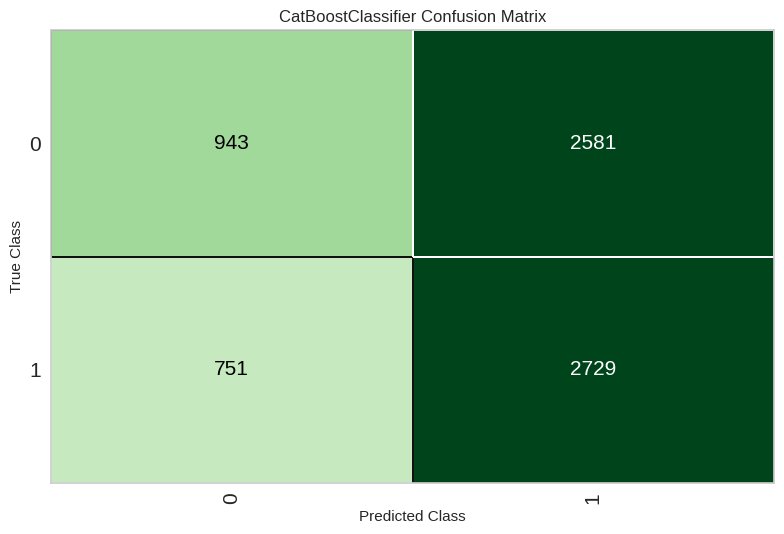

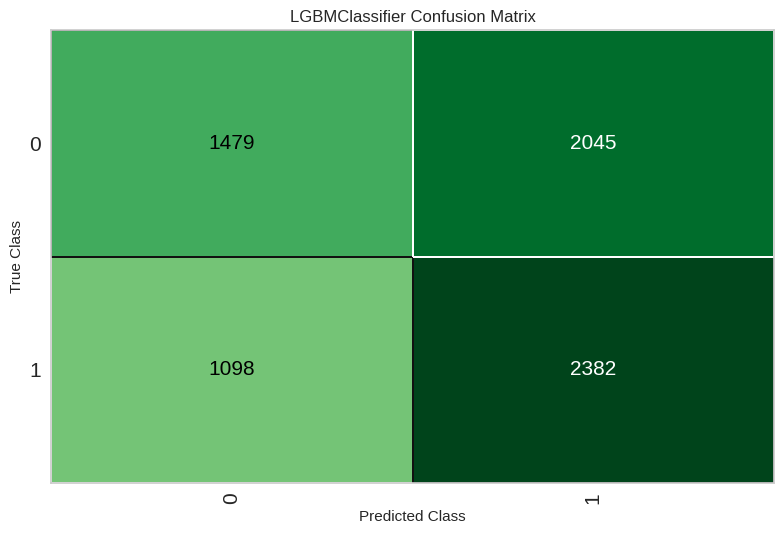

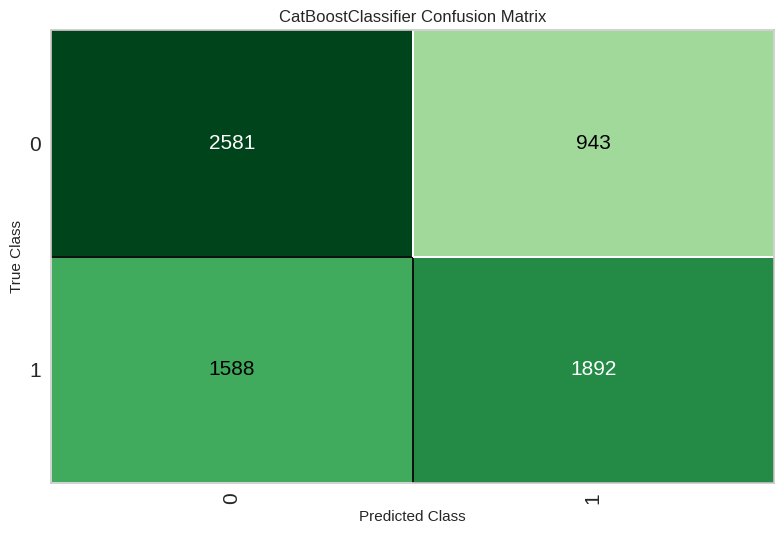

In [ ]:
plot_model(best_short, plot = 'confusion_matrix')
plot_model(best_medium, plot = 'confusion_matrix')
plot_model(best_long, plot = 'confusion_matrix')

In [ ]:
save_model(best_short, 'PermitTime1')
save_model(best_medium, 'PermitTime2')
save_model(best_long, 'PermitTime3')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['APPLICATION_YEAR',
                                              'EST_CONST_COST'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude...
                                                               verbose=

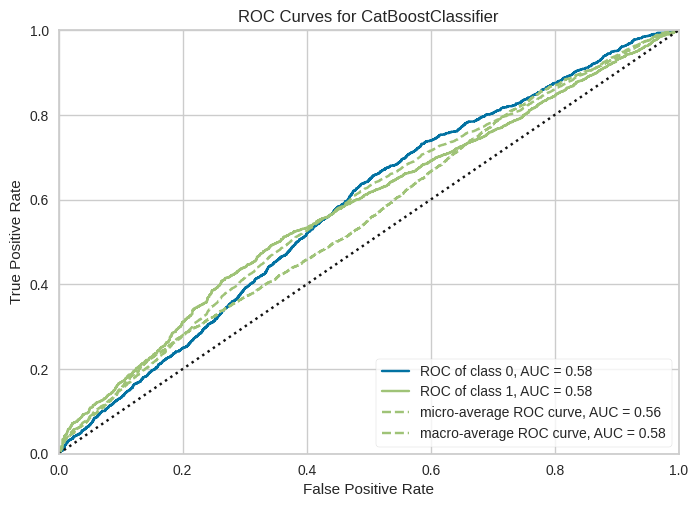

In [ ]:
plot_model(best_short, plot = 'auc')

In [40]:
dfc = pd.read_csv('building-permits-active-permits.csv', usecols=['PERMIT_NUM','PERMIT_TYPE','STRUCTURE_TYPE','WORK','POSTAL','APPLICATION_DATE','ISSUED_DATE','STATUS','EST_CONST_COST'],
                  dtype={"POSTAL": str, "EST_CONST_COST": str})

# 5. Dropping rows that have bad data such as empty postal codes, permit statuses that are not closed, estimated construction costs that are not numbers, null values.
#    Updating dataframe to have 8 columns for proposed features and target vector (To be constructed based on transformed data from the application data and issued date columns).

#print(dfc.STATUS.value_counts(), "\n")
dfc = dfc.drop(dfc[(dfc.STATUS != "Under Review") & (dfc.STATUS != "Application Received") & (dfc.STATUS != "Not Started")].index)
dfc = dfc[['PERMIT_NUM', 'PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK', 'POSTAL', 'APPLICATION_DATE', 'ISSUED_DATE', 'EST_CONST_COST']]
dfc = dfc.drop(dfc[pd.notna(dfc.ISSUED_DATE)].index)
dfc = dfc.drop('ISSUED_DATE', axis=1)
dfc = dfc.dropna()


# 6. Formatting estimated construction cost column to be only integers by purging commas and rows with values less than $100.
dfc = dfc.drop(dfc[(dfc.POSTAL == "   ") | (dfc.EST_CONST_COST == "DO NOT UPDATE OR DELETE THIS INFO FIELD")].index)
dfctemp = ((dfc['EST_CONST_COST'].replace(",","", regex=True)).astype(float)).astype(int)
dfc = dfc.drop('EST_CONST_COST', axis=1)
dfc = pd.concat([dfc, dfctemp], axis=1)
dfc = dfc.drop(dfc[dfc.EST_CONST_COST < 100].index)



# 7. Getting value counts from permit type, work, and structure type. Removing value counts less than a particular threshold to have a small set of highly populated types rather than a large set of varied data.
#df = df[~df['PERMIT_TYPE'].isin((df['PERMIT_TYPE'].value_counts())[(df['PERMIT_TYPE'].value_counts()) < 500].index)]
#df = df[~df['WORK'].isin((df['WORK'].value_counts())[(df['WORK'].value_counts()) < 1000].index)]
#df = df[~df['STRUCTURE_TYPE'].isin((df['STRUCTURE_TYPE'].value_counts())[(df['STRUCTURE_TYPE'].value_counts()) < 500].index)]
# 7a. Removing duplicate permit numbers.
dfc = dfc[~dfc['PERMIT_NUM'].isin((dfc['PERMIT_NUM'].value_counts())[(dfc['PERMIT_NUM'].value_counts()) > 1].index)]

# 7b. Viewing value counts.
#print(df.PERMIT_NUM.value_counts(), "\n")
#print(df.POSTAL.value_counts(), "\n")
#print(df.PERMIT_TYPE.value_counts(), "\n")
#print(df.WORK.value_counts(),"\n")
#print(df.STRUCTURE_TYPE.value_counts(), "\n")

# 8. Extracting year from permit number (First two digits) for years above and below 2000. Creating new column for application year.
perm_num_temp = 2000 + (dfc['PERMIT_NUM'].astype(str).str[0:2]).astype(int)
perm_num_temp = perm_num_temp - 100*(perm_num_temp > 2050)
app_num_temp = (dfc['APPLICATION_DATE'].astype(str).str[0:4]).astype(int)
# 8a. Checking for consistency in year between permit number year and applied year. Values that do not match are assigned a year of 0 to be filered out by the application year cutoff (In this case, 2021).
app_year = pd.DataFrame({'APPLICATION_YEAR' : perm_num_temp*(perm_num_temp == app_num_temp)})
dfc = pd.concat([app_year, dfc], axis=1)
dfc = dfc.drop(dfc[dfc.APPLICATION_YEAR < 2021].index)

# 11. Drop original columns (Permit number, Application date, Issued date) that will be replaced by the transformed data (Application year, process time).
dfc = dfc.drop(['PERMIT_NUM', 'APPLICATION_DATE'], axis=1)
# 11a. Dropping null values.
df = df.dropna()

# 12. Dropping columns to test classification.
#df = df.drop(['PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK'], axis=1)
#df = df.drop(['APPLICATION_YEAR', 'POSTAL', 'EST_CONST_COST'], axis=1)

#Printing cleaned data.

#print(df['PROJECT_TYPE'].value_counts(), "\n")


dfc

,APPLICATION_YEAR,PERMIT_TYPE,STRUCTURE_TYPE,WORK,POSTAL,EST_CONST_COST
218809,2022,Plumbing(PS),Apartment Building,Other(PS),M9V,70000
222765,2022,Plumbing(PS),Apartment Building,Backflow Prevention Devices (Water only),M4E,5000
224869,2022,Building Additions/Alterations,"Hair, Barber and Other Salon",Interior Alterations,M1H,40000
229653,2022,Drain and Site Service,Apartment Building,Site Service,M6P,10000
233713,2023,Mechanical(MS),Multiple Unit Building,Special Ventilation System,M8Z,30000
...,...,...,...,...,...,...
254787,2023,Drain and Site Service,SFD - Semi-Detached,Inside and Outside Drains,M6P,9000
254816,2023,Small Residential Projects,SFD - Semi-Detached,Party Wall Admin Permits,M4J,1000
254818,2023,Small Residential Projects,Laneway / Rear Yard Suite,New Laneway / Rear Yard Suite,M1C,40000
254839,2023,Small Residential Projects,SFD - Detached,Underpinning,M4W,150000
